In [56]:
import sys, os
# necessary to find ros packages
sys.path.append('/opt/ros/humble/local/lib/python3.10/dist-packages')

import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage
from models.map import Map
from models.point import Point
import yaml
import math

In [57]:
base_path ="../../out/tracks/track_4/"

Get Costmap and trajectory

In [58]:
with open(os.path.join(base_path, "costmap/map.npy"),'rb') as f:
        occupancy_grid = np.load(f)

with (open(os.path.join(base_path, "costmap/map.yaml"), 'rb')) as f:
    occupancy_grid_config = yaml.safe_load(f)

    occupancy_grid = (occupancy_grid != 0) * 1

    resolution = occupancy_grid_config["resolution"]
    occupancy_map = Map(occupancy_grid, resolution, Point(occupancy_grid_config["origin_x"] - resolution, occupancy_grid_config["origin_y"] -resolution))

path_meters = []
path_pixels = []
with open(os.path.join(base_path, "trajectory_mincurv.csv"), "r") as f:
    lines = f.readlines()
    for line in lines:
        # ignore comment lines
        if line.startswith('#'):
            continue
        parts = line.split(',')
        assert len(parts) == 3, line
        point = Point(float(parts[0]), float(parts[1]))
        path_meters.append(point)
        path_pixels.append(occupancy_map.world_point_to_grid_point(point))


In [59]:
object = np.zeros_like(occupancy_grid)
object[600:650, 1000:1200] = 2

occupancy_grid_with_object = occupancy_map.grid + object
occupancy_grid_with_object[occupancy_grid_with_object > 2] = 2
occupancy_map.grid = occupancy_grid_with_object

In [60]:
current_pos_pixels = Point(1100, 1000)
current_pos_meters = occupancy_map.grid_point_to_world_point(current_pos_pixels)

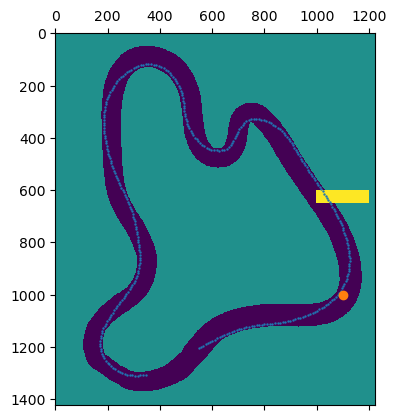

In [61]:
plt.matshow(occupancy_map.grid)
plt.scatter([point.x for point in path_pixels], [point.y for point in path_pixels], s=0.5)
plt.scatter(current_pos_pixels.x, current_pos_pixels.y)


In [62]:
def find_closest_point_idx_on_path(path: list[Point], reference_point: Point):
    closest_distance = np.inf
    closest_point_idx = None

    for i, point in enumerate(path):
        distance = math.sqrt((point.x - reference_point.x)**2 + (point.y - reference_point.y)**2)
        if(distance < closest_distance):
            closest_distance = distance
            closest_point_idx = i
    return closest_point_idx

def extend_path_into_future(path_meters: list[Point], path_pixels: list[Point], start_idx: int, extension_distance_meters: float):
    current_pos_meters=path_meters[start_idx]
    current_pos_pixels=path_pixels[start_idx]
    
    extended_path_meters = [current_pos_meters]
    extended_path_pixels = [current_pos_pixels]
    running_distance = 0

    for i,point in enumerate(path_meters[start_idx + 1:]):
        distance = math.sqrt((point.x - extended_path_meters[-1].x)**2 + (point.y - extended_path_meters[-1].y)**2)
        running_distance += distance
        if(running_distance > extension_distance_meters):
            break
        extended_path_meters.append(point)
        extended_path_pixels.append(path_pixels[start_idx + i])
    
    return extended_path_meters, extended_path_pixels



Find closes point and all points ahead at most 10 meters

In [63]:
# find closest point
closest_point_idx = find_closest_point_idx_on_path(path_meters, current_pos_meters)
closest_point_meters = path_meters[closest_point_idx]
closest_point_pixels = path_pixels[closest_point_idx]

lookahead_path_meters, lookahead_path_pixels = extend_path_into_future(path_meters, path_pixels, closest_point_idx, 30)

    


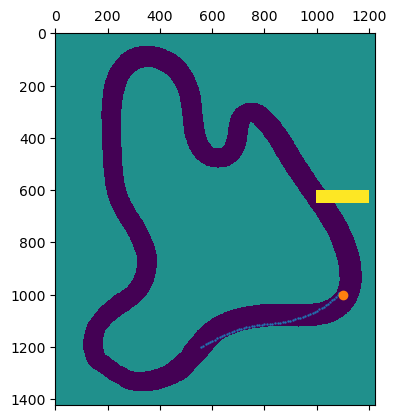

In [64]:
plt.matshow(occupancy_map.grid)
plt.scatter([point.x for point in lookahead_path_pixels], [point.y for point in lookahead_path_pixels], s=0.5)
plt.scatter(current_pos_pixels.x, current_pos_pixels.y)

Check path for collisions

In [65]:
def check_path_for_collision(path: list[Point], min_margin: float, distance_grid: np.ndarray):
    has_collided = False
    collision_idx = None

    for i, point in enumerate(path):
        if(distance_grid[point.y, point.x] < min_margin):
            has_collided = True
            collision_idx = i
            break
    return has_collided, collision_idx


In [66]:
width_car_meters = 1
margin_meters = width_car_meters / 2
margin_pixels = margin_meters / occupancy_map.resolution
distance_to_objects_pixels = ndimage.distance_transform_edt(occupancy_map.grid != 2)

has_collided, collision_idx = check_path_for_collision(lookahead_path_pixels, margin_pixels, distance_to_objects_pixels)
collision_idx = collision_idx + closest_point_idx

print(f"has collided: {has_collided}")


TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'

Find closes point after object that is far enough away from object

In [ ]:
idx_after_initial_collision = collision_idx + 1

first_valid_idx = None
for i, point in enumerate(path_pixels[idx_after_initial_collision:]):
    distance_pixels = distance_to_objects_pixels[point.y, point.x]
    if distance_pixels > margin_pixels:
        first_valid_idx = idx_after_initial_collision + i
        break

print(first_valid_idx)

330


Once again extend path, to not make going back to reference path to abrupt

In [ ]:
# extend trajectory for next x meters
path_extension_distance_meters = 5

extension_path_meters, extension_path_pxiels = extend_path_into_future(path_meters, path_pixels, first_valid_idx, path_extension_distance_meters)


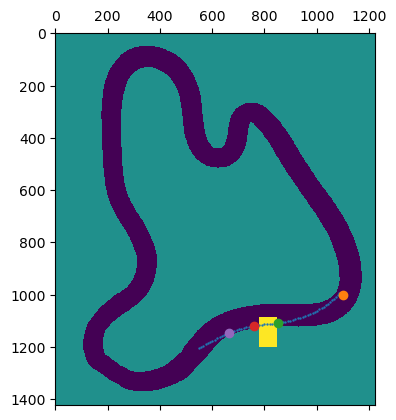

In [ ]:
plt.matshow(occupancy_map.grid)
plt.scatter([point.x for point in lookahead_path_pixels], [point.y for point in lookahead_path_pixels], s=0.5)
plt.scatter(current_pos_pixels.x, current_pos_pixels.y)

plt.scatter(path_pixels[collision_idx].x, path_pixels[collision_idx].y)
plt.scatter(path_pixels[first_valid_idx].x, path_pixels[first_valid_idx].y)
plt.scatter(extension_path_pxiels[-1].x, extension_path_pxiels[-1].y)


Using our simple A star, calculate a minimum distance path that avoid the objects

In [ ]:
import heapq

class Node:
    def __init__(self, coordinate: Point, f_score):
        self.coordinate = coordinate
        self.f_score = f_score

    def __lt__(self, other):
        return self.f_score < other.f_score



class AStar:
    @classmethod
    def find_path(cls, start: Point, goal: Point, classified_grid: np.ndarray) -> list[Point]:
        """
        Finds shortest path between two points using a-star

        classified_grid must be of such form that all valid points have value 0 and all invalid points have value 1
        """
        # General initializazion
        assert classified_grid[start.y, start.x] == 0 and classified_grid[goal.y, goal.x] == 0

        # allow moves in all directions
        neighbors = [Point(0, 1), Point(0, -1), Point(1, 0), Point(-1, 0),
        Point(1, 1), Point(1, -1), Point(-1, 1), Point(-1, -1)]

        
        open_heap = []
        closed_set = set()

        came_from = {}

        # add initial point to open list
        gscore = {start: 0}
        fscore = {start: cls._heuristic(start, goal)}

        heapq.heappush(open_heap, Node(start, fscore[start]))

        while open_heap:
            current_point = heapq.heappop(open_heap).coordinate

            # reached goal -> backwards calculate path
            if current_point == goal:
                print("backsolve")
                return cls._backsolve_path(current_point, came_from)

            # Continue path finding
            closed_set.add(current_point)

            # go over all neighbors
            for direction in neighbors:
                neighbor = current_point + direction

                tentative_g_score = gscore[current_point] + math.sqrt(direction.x**2 + direction.y**2)

                if not cls._check_new_point(neighbor, classified_grid):
                    continue

                if neighbor in closed_set: 
                    continue

                if tentative_g_score < gscore.get(neighbor, float('inf')):
                    came_from[neighbor] = current_point
                    gscore[neighbor] = tentative_g_score
                    fscore[neighbor] = tentative_g_score + \
                        cls._heuristic(neighbor, goal)

                    heapq.heappush(open_heap, Node(neighbor, fscore[neighbor]))
        
        raise ValueError("No path exists between pints")



    @classmethod
    def _heuristic(cls, a: Point, b: Point):
        return np.sqrt((b.x - a.x) ** 2 + (b.y - a.y) ** 2)

    @classmethod
    def _backsolve_path(cls, end: Node, came_from):
        current = end
        path = []
        while current in came_from:
            path.append(current)
            current = came_from[current]
        return path

    @classmethod
    def _check_new_point(cls, point: Point, classified_grid: np.ndarray):
        if point.x < 0 or point.x > classified_grid.shape[1]:
            return False
        if point.y < 0 or point.y > classified_grid.shape[0]:
            return False
        if classified_grid[point.y, point.x] == 1:
            return False

        return True

In [ ]:
start_point = closest_point_pixels
end_point = extension_path_pxiels[-1]

distance_to_letal = ndimage.distance_transform_edt(occupancy_map.grid == 0)
width_filterd_grid = (distance_to_letal < margin_pixels) * 1

assert width_filterd_grid[start_point.y, start_point.x] == 0
assert width_filterd_grid[end_point.y, end_point.x] == 0

path = AStar.find_path(start_point, end_point, width_filterd_grid)

backsolve


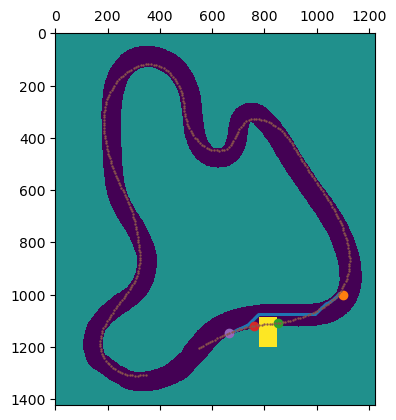

In [ ]:
plt.matshow(occupancy_map.grid)
plt.scatter([point.x for point in path], [point.y for point in path], s=0.5)
plt.scatter(current_pos_pixels.x, current_pos_pixels.y)
plt.scatter(path_pixels[collision_idx].x, path_pixels[collision_idx].y)
plt.scatter(path_pixels[first_valid_idx].x, path_pixels[first_valid_idx].y)
plt.scatter(extension_path_pxiels[-1].x, extension_path_pxiels[-1].y)
plt.scatter([point.x for point in path_pixels], [point.y for point in path_pixels], s=0.5)
